In [2]:
import os
import math
import random
from typing import Callable, Optional, Tuple, List, Dict

import numpy as np
import pandas as pd
import torch
from torch import nn, Tensor, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from PIL import Image
from torchinfo import summary
from torchmetrics import Metric
from torchmetrics.classification import MulticlassAccuracy
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# =====================================================================
# Paths & constants
# =====================================================================

DATA_ROOT = "/Users/bhoomi/Documents/COMP 6771/Project"  
TRAIN_ROOT = os.path.join(DATA_ROOT, "train")
TEST_ROOT  = os.path.join(DATA_ROOT, "test")

NUM_DIGIT_CLASSES = 10          # 0–9
MAX_SEQUENCE_LEN = 5            # up to 5 digits
SINGLE_DIGIT_SIZE = 32          # each digit is 32x32


In [4]:
# =====================================================================
# Config & reproducibility
# =====================================================================

class Config:
    """Container for all tunable parameters."""
    # Reproducibility
    seed: int = 42

    # Device
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model / slicing
    stride: int = 16
    kernel_size: int = 3

    # Dataloading
    batch_size: int = 32
    num_workers: int = 0
    prefetch_factor: Optional[int] = None

    # Optimization
    lr: float = 1e-3
    weight_decay: float = 0.0
    epochs: int = 10

def set_global_seed(seed: int) -> None:
    """Set all seeds to make runs more reproducible."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


CFG = Config()
set_global_seed(CFG.seed)


In [5]:
# =====================================================================
# Dataset
# =====================================================================

class MultiDigitMNISTDataset(Dataset):
    """
    Dataset for images containing multiple MNIST digits in a row.
    Label is parsed from the filename, e.g. 'img_12345.png' -> [1,2,3,4,5].
    """

    def __init__(
        self,
        root_dir: str,
        max_digits: int,
        ext: str = ".png",
        img_transform: Optional[Callable[[np.ndarray], Tensor]] = None,
        label_transform: Optional[Callable[[np.ndarray], Tensor]] = None,
    ) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.max_digits = max_digits
        self.ext = ext
        self.img_transform = img_transform
        self.label_transform = label_transform

        self.files = self._collect_filenames()

    def _collect_filenames(self) -> List[str]:
        all_files = os.listdir(self.root_dir)
        # keep only desired extension
        image_files = [f for f in all_files if os.path.splitext(f)[-1] == self.ext]
        return sorted(image_files)

    def __len__(self) -> int:
        return len(self.files)

    def _parse_label_from_name(self, filename: str) -> np.ndarray:
        """Extract label digits from filename."""
        base = os.path.splitext(filename)[0]
        digit_str = base.split("_")[-1]  # assume label at the end
        digits = [int(ch) for ch in digit_str]
        return np.array(digits, dtype=np.uint8)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        filename = self.files[idx]

        # Label
        raw_label = self._parse_label_from_name(filename)

        # Image
        img_path = os.path.join(self.root_dir, filename)
        img = Image.open(img_path)
        img_np = np.array(img, dtype=np.uint8)

        if self.label_transform is not None:
            label_tensor = self.label_transform(raw_label)
        else:
            label_tensor = torch.from_numpy(raw_label.astype(np.int64))

        if self.img_transform is not None:
            img_tensor = self.img_transform(img_np)
        else:
            img_tensor = torch.from_numpy(img_np).unsqueeze(0).float() / 255.0

        return img_tensor, label_tensor


# Quick sanity checks / visualization helpers
def show_random_samples(dataset: MultiDigitMNISTDataset, n: int = 5) -> None:
    n = min(n, len(dataset))
    indices = np.random.choice(len(dataset), size=n, replace=False)

    fig, axes = plt.subplots(nrows=n, figsize=(14, 3 * n))
    if n == 1:
        axes = [axes]

    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]
        ax.imshow(img.squeeze().numpy(), cmap="gray")
        ax.set_title("Label: " + "".join(map(str, label.tolist())))
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def show_images_with_labels(images: Tensor, labels: List[int]) -> None:
    images = images.cpu().numpy()
    fig, axes = plt.subplots(nrows=len(images), figsize=(12, 3 * len(images)))
    if len(images) == 1:
        axes = [axes]

    for ax, img, lbl in zip(axes, images, labels):
        ax.imshow(img.squeeze(), cmap="gray")
        ax.set_title(f"Predicted: {lbl}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    



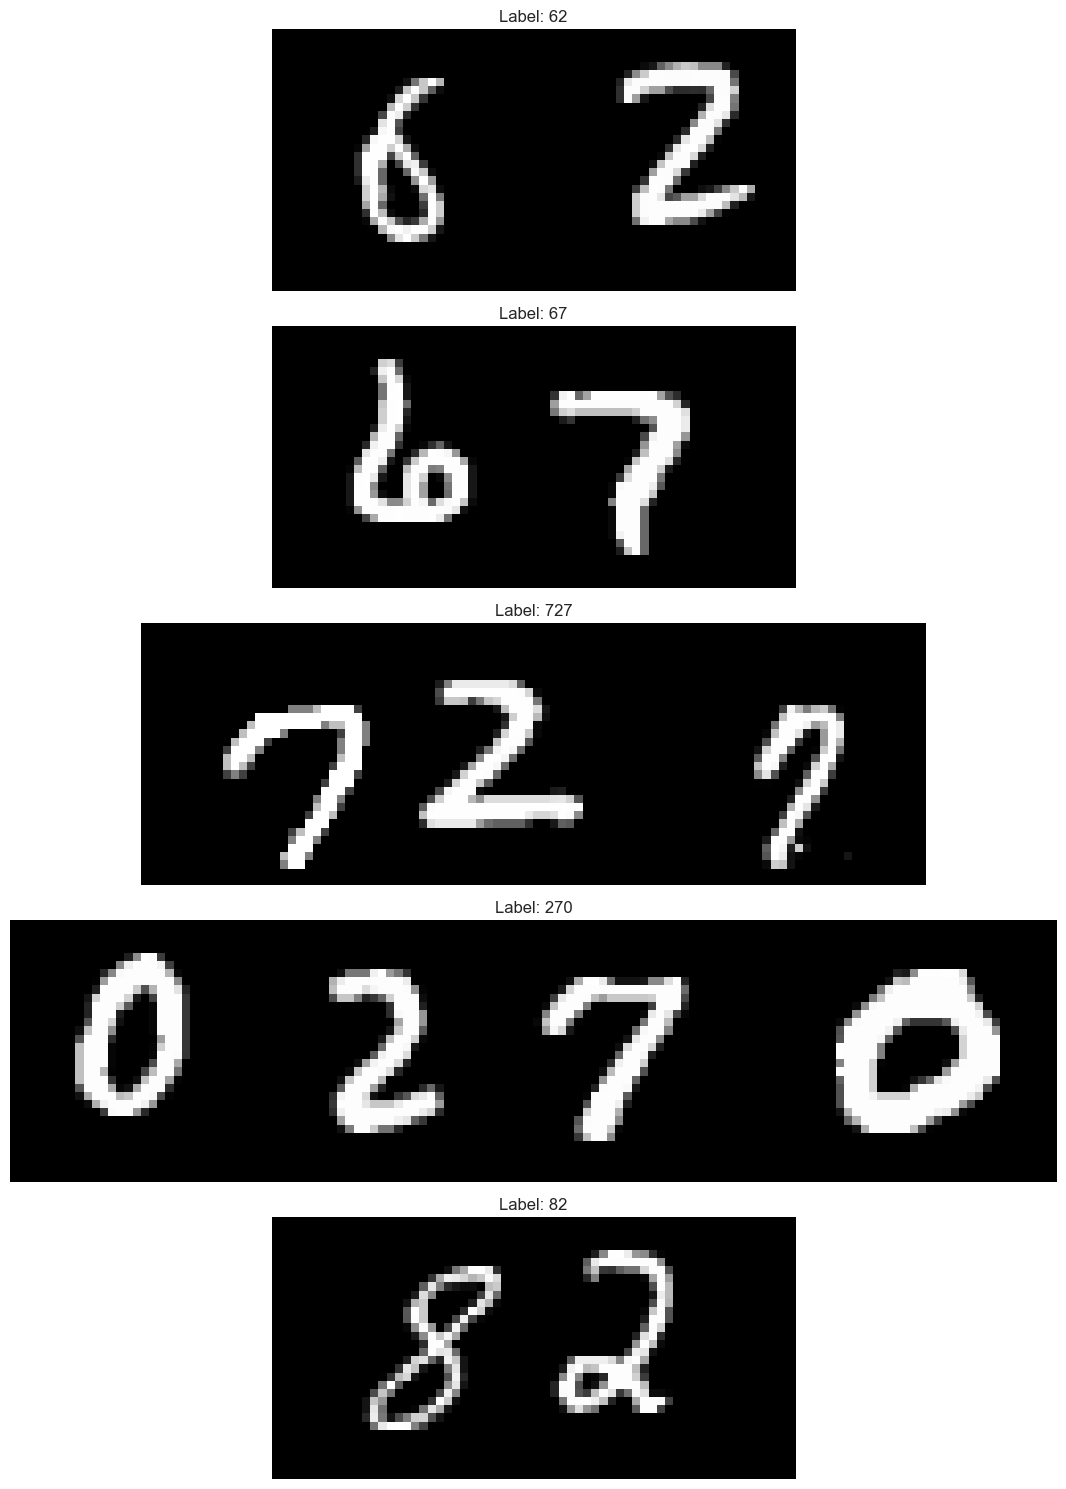

In [6]:
# =====================================================================
# Preprocessing
# =====================================================================

def encode_label(label: np.ndarray) -> Tensor:
    """
    Pad the sequence of digits on the left with a 'blank' class (NUM_DIGIT_CLASSES)
    so that every label has length MAX_SEQUENCE_LEN.
    """
    # blank = NUM_DIGIT_CLASSES
    pad_len = MAX_SEQUENCE_LEN - len(label)
    pad = np.full((pad_len,), NUM_DIGIT_CLASSES, dtype=np.uint8)
    full_seq = np.concatenate([pad, label], axis=0)
    return torch.tensor(full_seq, dtype=torch.long)


def preprocess_image(img: np.ndarray) -> Tensor:
    """
    Pad the image horizontally so that it always has width SINGLE_DIGIT_SIZE * MAX_SEQUENCE_LEN.
    """
    h, w = img.shape
    target_width = SINGLE_DIGIT_SIZE * MAX_SEQUENCE_LEN
    if w < target_width:
        pad = np.zeros((h, target_width - w), dtype=np.uint8)
        img = np.concatenate([pad, img], axis=1)
    img_tensor = torch.from_numpy(img.astype(np.float32)).unsqueeze(0) / 255.0
    return img_tensor


# Small local check
if os.path.exists(TRAIN_ROOT):
    tmp_dataset = MultiDigitMNISTDataset(
        root_dir=TRAIN_ROOT,
        max_digits=MAX_SEQUENCE_LEN,
        ext=".png",
    )
    show_random_samples(tmp_dataset, n=5)

In [7]:
# =====================================================================
# Model
# =====================================================================

class BasicCNNBlock(nn.Module):
    """
    Simple 2x conv + ReLU + MaxPool block.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        pool_size: int,
    ) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool_size),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class Backbone(nn.Module):
    """
    CNN backbone that converts a 32x32 digit patch into a 128-dim feature vector.
    """

    def __init__(self) -> None:
        super().__init__()
        self.embed_dim = 128

        self.backbone = nn.Sequential(
            BasicCNNBlock(1, 8, 3, 1, 1, 2),     # 1x32x32 -> 8x16x16
            BasicCNNBlock(8, 16, 3, 1, 1, 2),    # 8x16x16 -> 16x8x8
            BasicCNNBlock(16, 32, 3, 1, 1, 2),   # 16x8x8 -> 32x4x4
            BasicCNNBlock(32, 64, 3, 1, 1, 2),   # 32x4x4 -> 64x2x2
            BasicCNNBlock(64, 128, 3, 1, 1, 2),  # 64x2x2 -> 128x1x1
            nn.Flatten(),                        # 128x1x1 -> 128
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.backbone(x)
    
class MultiDigitModel(nn.Module):
    def __init__(
        self,
        num_classes: int,
        num_digits: int,
        stride: int = 32,
        kernel_size: int = 2,
    ) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.num_digits = num_digits
        self.stride = stride

        num_channels = int(math.ceil((SINGLE_DIGIT_SIZE * num_digits - SINGLE_DIGIT_SIZE) / stride) + 1)
        self.channels_count = num_channels
        self.kernel_size = kernel_size

        self.backbone = Backbone()

        self.conv1d = nn.Conv1d(
            in_channels=self.channels_count,
            out_channels=self.num_digits,
            kernel_size=self.kernel_size,
            stride=1,
            padding="same",
        )

        self.classifier = nn.Linear(self.backbone.embed_dim, self.num_classes)

    def forward(self, x: Tensor) -> Tensor:
        """
        x: [B, 1, 32, 32 * num_digits]
        returns: [B, num_digits, num_classes]
        """
        # Unfold along width into 32-pixel wide windows
        # x: (B, 1, 32, 32*num_digits) -> (B, 1, 32, num_windows, 32)
        x = x.unfold(dimension=-1, size=SINGLE_DIGIT_SIZE, step=self.stride)

        # Put window dimension next to batch: (B, 1, 32, num_windows, 32) -> (B, num_windows, 1, 32, 32)
        x = x.permute(0, 3, 1, 2, 4)  
        B, num_windows, C, H, W = x.shape

        # Merge batch and window dims for CNN: (B * num_windows, 1, 32, 32)
        x = x.reshape(B * num_windows, C, H, W)

        # CNN backbone
        features = self.backbone(x)  # (B * num_windows, 128)

        # Restore window dimension: (B, num_windows, 128)
        features = features.view(B, num_windows, self.backbone.embed_dim)

        # Light sequence modeling over windows
        seq_feat = self.conv1d(features)  # (B, num_digits, 128) after conv1d

        # Per-digit classification
        logits = self.classifier(seq_feat)  # (B, num_digits, num_classes)

        return logits



# small shape check
dummy_model = MultiDigitModel(num_classes=NUM_DIGIT_CLASSES + 1, num_digits=MAX_SEQUENCE_LEN,
                              stride=CFG.stride, kernel_size=CFG.kernel_size)
dummy_input = torch.zeros(2, 1, SINGLE_DIGIT_SIZE, SINGLE_DIGIT_SIZE * MAX_SEQUENCE_LEN)
summary(dummy_model, input_data=dummy_input, device="cpu", depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
MultiDigitModel                               [2, 5, 11]                --
├─Backbone: 1-1                               [18, 128]                 --
│    └─Sequential: 2-1                        [18, 128]                 --
│    │    └─BasicCNNBlock: 3-1                [18, 8, 16, 16]           664
│    │    └─BasicCNNBlock: 3-2                [18, 16, 8, 8]            3,488
│    │    └─BasicCNNBlock: 3-3                [18, 32, 4, 4]            13,888
│    │    └─BasicCNNBlock: 3-4                [18, 64, 2, 2]            55,424
│    │    └─BasicCNNBlock: 3-5                [18, 128, 1, 1]           221,440
│    │    └─Flatten: 3-6                      [18, 128]                 --
├─Conv1d: 1-2                                 [2, 5, 128]               140
├─Linear: 1-3                                 [2, 5, 11]                1,419
Total params: 296,463
Trainable params: 296,463
Non-trainable params: 0
To

In [8]:
# =====================================================================
# Loss & metrics
# =====================================================================

class Seq2SeqCrossEntropyLoss(nn.Module):
    """
    Cross-entropy loss applied per digit position, averaged over all digits and batch.
    """

    def __init__(self) -> None:
        super().__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits: Tensor, targets: Tensor) -> Tensor:
        """
        logits:  [B, N, C]
        targets: [B, N]
        """
        B, N, C = logits.shape
        logits_flat = logits.view(B * N, C)
        targets_flat = targets.view(B * N)
        return self.ce(logits_flat, targets_flat)


class Seq2SeqPartialAccuracy:
    """
    Average per-position accuracy (how many digit positions are correct on average).
    """

    def __init__(self, num_classes: int) -> None:
        self.metric = MulticlassAccuracy(num_classes=num_classes)

    def __call__(self, logits: Tensor, targets: Tensor) -> Tensor:
        B, N, C = logits.shape
        logits_flat = logits.view(B * N, C)
        targets_flat = targets.view(B * N)
        return self.metric(logits_flat, targets_flat)

    def to(self, device: torch.device) -> "Seq2SeqPartialAccuracy":
        self.metric = self.metric.to(device)
        return self


class Seq2SeqExactAccuracy:
    """
    Sequence-level accuracy: a prediction is counted as correct only
    if ALL digit positions are predicted correctly.
    """

    def __call__(self, logits: Tensor, targets: Tensor) -> Tensor:
        """
        logits:  [B, N, C]
        targets: [B, N]
        """
        preds = logits.argmax(dim=-1)          # [B, N]
        correct_per_sequence = (preds == targets).all(dim=-1)  # [B]
        return correct_per_sequence.float().mean()

    def to(self, device: torch.device) -> "Seq2SeqExactAccuracy":
        # No internal tensors, so nothing to move.
        return self


In [9]:
# =====================================================================
# Dataloaders
# =====================================================================

train_dataset = MultiDigitMNISTDataset(
    root_dir=TRAIN_ROOT,
    max_digits=MAX_SEQUENCE_LEN,
    ext=".png",
    img_transform=preprocess_image,
    label_transform=encode_label,
)

val_dataset = MultiDigitMNISTDataset(
    root_dir=TEST_ROOT,
    max_digits=MAX_SEQUENCE_LEN,
    ext=".png",
    img_transform=preprocess_image,
    label_transform=encode_label,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
    prefetch_factor=CFG.prefetch_factor,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
    prefetch_factor=CFG.prefetch_factor,
)



In [10]:
# =====================================================================
# Train
# =====================================================================

model = MultiDigitModel(
    num_classes=NUM_DIGIT_CLASSES + 1,  # 0–9 plus "blank"
    num_digits=MAX_SEQUENCE_LEN,
    stride=CFG.stride,
    kernel_size=CFG.kernel_size, 
)

def train(
    model: nn.Module,
    loss_fn: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    learning_rate: float,
    weight_decay: float,
    epochs: int,
    metrics: Dict[str, Metric],
    device: torch.device,
    show_progress: bool = True,
    verbose: bool = True,
) -> pd.DataFrame:

    # --- history dict ---
    history = {"epoch": [], "split": [], "loss": []}
    for metric_name in metrics:
        history[metric_name] = []
        # move metric to device if it has .to()
        if hasattr(metrics[metric_name], "to"):
            metrics[metric_name] = metrics[metric_name].to(device)

    # --- setup model, loss, optimizer ---
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    optimizer = optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    for epoch in range(epochs):
        if verbose:
            print(f"\n===== Epoch {epoch + 1}/{epochs} =====")

        # =====================================================
        # TRAIN LOOP
        # =====================================================
        if show_progress:
            train_iter = tqdm(
                train_loader,
                desc=f"Train {epoch + 1}/{epochs}",
                total=len(train_loader),
                ncols=80,        # keep bar narrow
                leave=False,     # <- key: don't leave long bar history
                mininterval=0.3, # reduce spam
            )
        else:
            train_iter = train_loader

        model.train()
        running_loss = 0.0
        all_logits = []
        all_targets = []

        for x, y in train_iter:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_logits.append(outputs.detach())
            all_targets.append(y.detach())

        all_logits = torch.cat(all_logits)
        all_targets = torch.cat(all_targets)

        avg_train_loss = running_loss / len(train_loader)

        history["epoch"].append(epoch)
        history["split"].append("train")
        history["loss"].append(avg_train_loss)

        for name, metric in metrics.items():
            history[name].append(metric(all_logits, all_targets).item())

        if verbose:
            msg = "[Train] loss={:.4f} ".format(avg_train_loss) + " ".join(
                f"{name}={history[name][-1]:.4f}" for name in metrics
            )
            print(msg)

        del all_logits, all_targets

        # =====================================================
        # VALIDATION LOOP
        # =====================================================
        if show_progress:
            val_iter = tqdm(
                val_loader,
                desc=f"Val   {epoch + 1}/{epochs}",
                total=len(val_loader),
                ncols=80,
                leave=False,
                mininterval=0.3,
            )
        else:
            val_iter = val_loader

        model.eval()
        running_loss = 0.0
        all_logits = []
        all_targets = []

        with torch.no_grad():
            for x, y in val_iter:
                x, y = x.to(device), y.to(device)

                outputs = model(x)
                loss = loss_fn(outputs, y)

                running_loss += loss.item()
                all_logits.append(outputs.detach())
                all_targets.append(y.detach())

        all_logits = torch.cat(all_logits)
        all_targets = torch.cat(all_targets)

        avg_val_loss = running_loss / len(val_loader)

        history["epoch"].append(epoch)
        history["split"].append("val")
        history["loss"].append(avg_val_loss)

        for name, metric in metrics.items():
            history[name].append(metric(all_logits, all_targets).item())

        if verbose:
            msg = "[Val]   loss={:.4f} ".format(avg_val_loss) + " ".join(
                f"{name}={history[name][-1]:.4f}" for name in metrics
            )
            print(msg)

    return pd.DataFrame(history)


history = train(
    model=model,
    loss_fn=Seq2SeqCrossEntropyLoss(),
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=CFG.lr,
    weight_decay=CFG.weight_decay,
    epochs=CFG.epochs,
    metrics={
        "exact-accuracy": Seq2SeqExactAccuracy(),
        "partial-accuracy": Seq2SeqPartialAccuracy(num_classes=NUM_DIGIT_CLASSES + 1),
    },
    device=CFG.device,
    show_progress=True,  
    verbose=True,
)




===== Epoch 1/10 =====


[Train] loss=0.5433 exact-accuracy=0.5579 partial-accuracy=0.7516


[Val]   loss=0.0734 exact-accuracy=0.8909 partial-accuracy=0.9692

===== Epoch 2/10 =====


[Train] loss=0.0625 exact-accuracy=0.9085 partial-accuracy=0.9750


[Val]   loss=0.0428 exact-accuracy=0.9329 partial-accuracy=0.9820

===== Epoch 3/10 =====


[Train] loss=0.0389 exact-accuracy=0.9414 partial-accuracy=0.9843


[Val]   loss=0.0335 exact-accuracy=0.9508 partial-accuracy=0.9867

===== Epoch 4/10 =====


[Train] loss=0.0307 exact-accuracy=0.9538 partial-accuracy=0.9875


[Val]   loss=0.0369 exact-accuracy=0.9439 partial-accuracy=0.9848

===== Epoch 5/10 =====


[Train] loss=0.0249 exact-accuracy=0.9634 partial-accuracy=0.9902


[Val]   loss=0.0316 exact-accuracy=0.9549 partial-accuracy=0.9881

===== Epoch 6/10 =====


[Train] loss=0.0205 exact-accuracy=0.9687 partial-accuracy=0.9917


[Val]   loss=0.0275 exact-accuracy=0.9627 partial-accuracy=0.9901

===== Epoch 7/10 =====


[Train] loss=0.0190 exact-accuracy=0.9706 partial-accuracy=0.9922


[Val]   loss=0.0311 exact-accuracy=0.9557 partial-accuracy=0.9883

===== Epoch 8/10 =====


[Train] loss=0.0157 exact-accuracy=0.9764 partial-accuracy=0.9938


[Val]   loss=0.0381 exact-accuracy=0.9503 partial-accuracy=0.9866

===== Epoch 9/10 =====


[Train] loss=0.0147 exact-accuracy=0.9779 partial-accuracy=0.9942


[Val]   loss=0.0304 exact-accuracy=0.9588 partial-accuracy=0.9889

===== Epoch 10/10 =====


[Train] loss=0.0131 exact-accuracy=0.9800 partial-accuracy=0.9947


[Val]   loss=0.0381 exact-accuracy=0.9539 partial-accuracy=0.9878


In [11]:
MODEL_PATH = "/Users/bhoomi/Documents/COMP 6771/Project/multidigit_cnn.pth"

torch.save({
    "model_state": model.state_dict(),
    "num_classes": NUM_DIGIT_CLASSES + 1,
    "num_digits": MAX_SEQUENCE_LEN,
    "stride": CFG.stride,
    "kernel_size": CFG.kernel_size,
}, MODEL_PATH)

print("Saved to:", MODEL_PATH)

Saved to: /Users/bhoomi/Documents/COMP 6771/Project/multidigit_cnn.pth


In [12]:
def load_multidigit_model(model_path: str, device=None) -> MultiDigitModel:
    ckpt = torch.load(model_path, map_location="cpu")

    loaded_model = MultiDigitModel(
        num_classes=ckpt["num_classes"],
        num_digits=ckpt["num_digits"],
        stride=ckpt["stride"],
        kernel_size=ckpt["kernel_size"],
    )

    loaded_model.load_state_dict(ckpt["model_state"])
    loaded_model.eval()

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    return loaded_model.to(device)


In [13]:
from PIL import Image
import numpy as np
import torch

def predict_sequence_from_image(
    img_path: str,
    model_path: str = "/Users/bhoomi/Documents/COMP 6771/Project/multidigit_cnn.pth",
    invert: bool = False,
    show: bool = False
) -> int:
    """
    img_path: path to multi-digit image (png/jpg)
    invert: True if digits are black on white background
    show: True to display preprocessed image
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_multidigit_model(model_path, device=device)

    # --- load image ---
    img = Image.open(img_path).convert("L")
    img_np = np.array(img, dtype=np.uint8)

    if invert:
        img_np = 255 - img_np

    # --- same preprocessing as training ---
    x = preprocess_image(img_np)     # [1, 32, 160]
    x = x.unsqueeze(0).to(device)    # [B=1, 1, 32, 160]

    # --- predict ---
    with torch.inference_mode():
        logits = model(x)                 # [1, N, C]
        seq = logits.argmax(dim=-1)[0]    # [N]

    blank_idx = model.num_classes - 1
    valid_digits = seq[seq != blank_idx].tolist()

    if not valid_digits:
        pred_number = 0
    else:
        pred_number = int("".join(map(str, valid_digits)))

    if show:
        import matplotlib.pyplot as plt
        plt.imshow(x[0,0].cpu(), cmap="gray")
        plt.title(f"Predicted: {pred_number}")
        plt.axis("off")
        plt.show()

    return pred_number


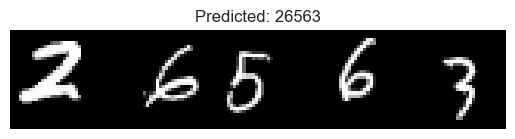

Predicted sequence: 26563


In [14]:
pred = predict_sequence_from_image(
    "//Users/bhoomi/Documents/COMP 6771/Final_Project/test/test_368_26563.png",
    invert=False,
    show=True
)

print("Predicted sequence:", pred)


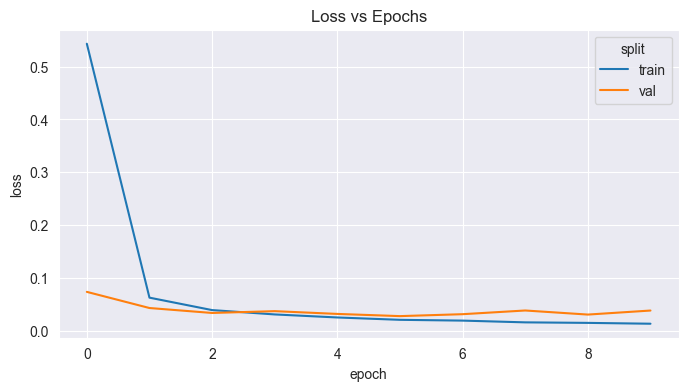

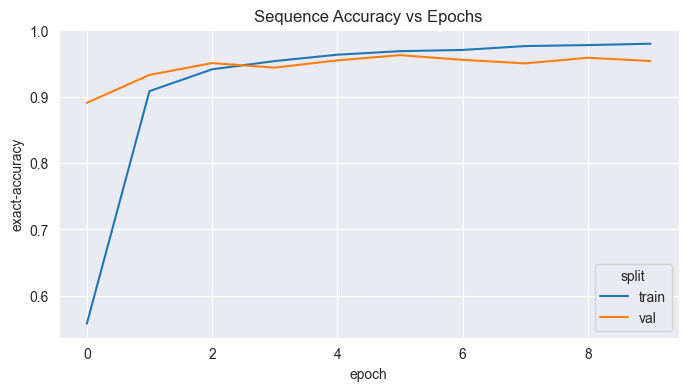

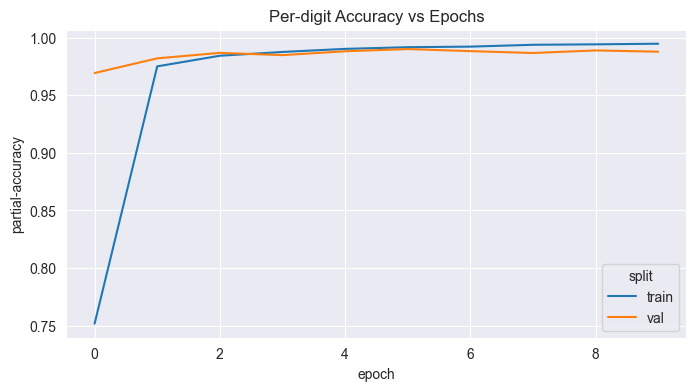

In [15]:
# =====================================================================
# Curves
# =====================================================================

plt.figure(figsize=(8, 4))
sns.lineplot(data=history, x="epoch", y="loss", hue="split")
plt.title("Loss vs Epochs")
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(data=history, x="epoch", y="exact-accuracy", hue="split")
plt.title("Sequence Accuracy vs Epochs")
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(data=history, x="epoch", y="partial-accuracy", hue="split")
plt.title("Per-digit Accuracy vs Epochs")
plt.show()


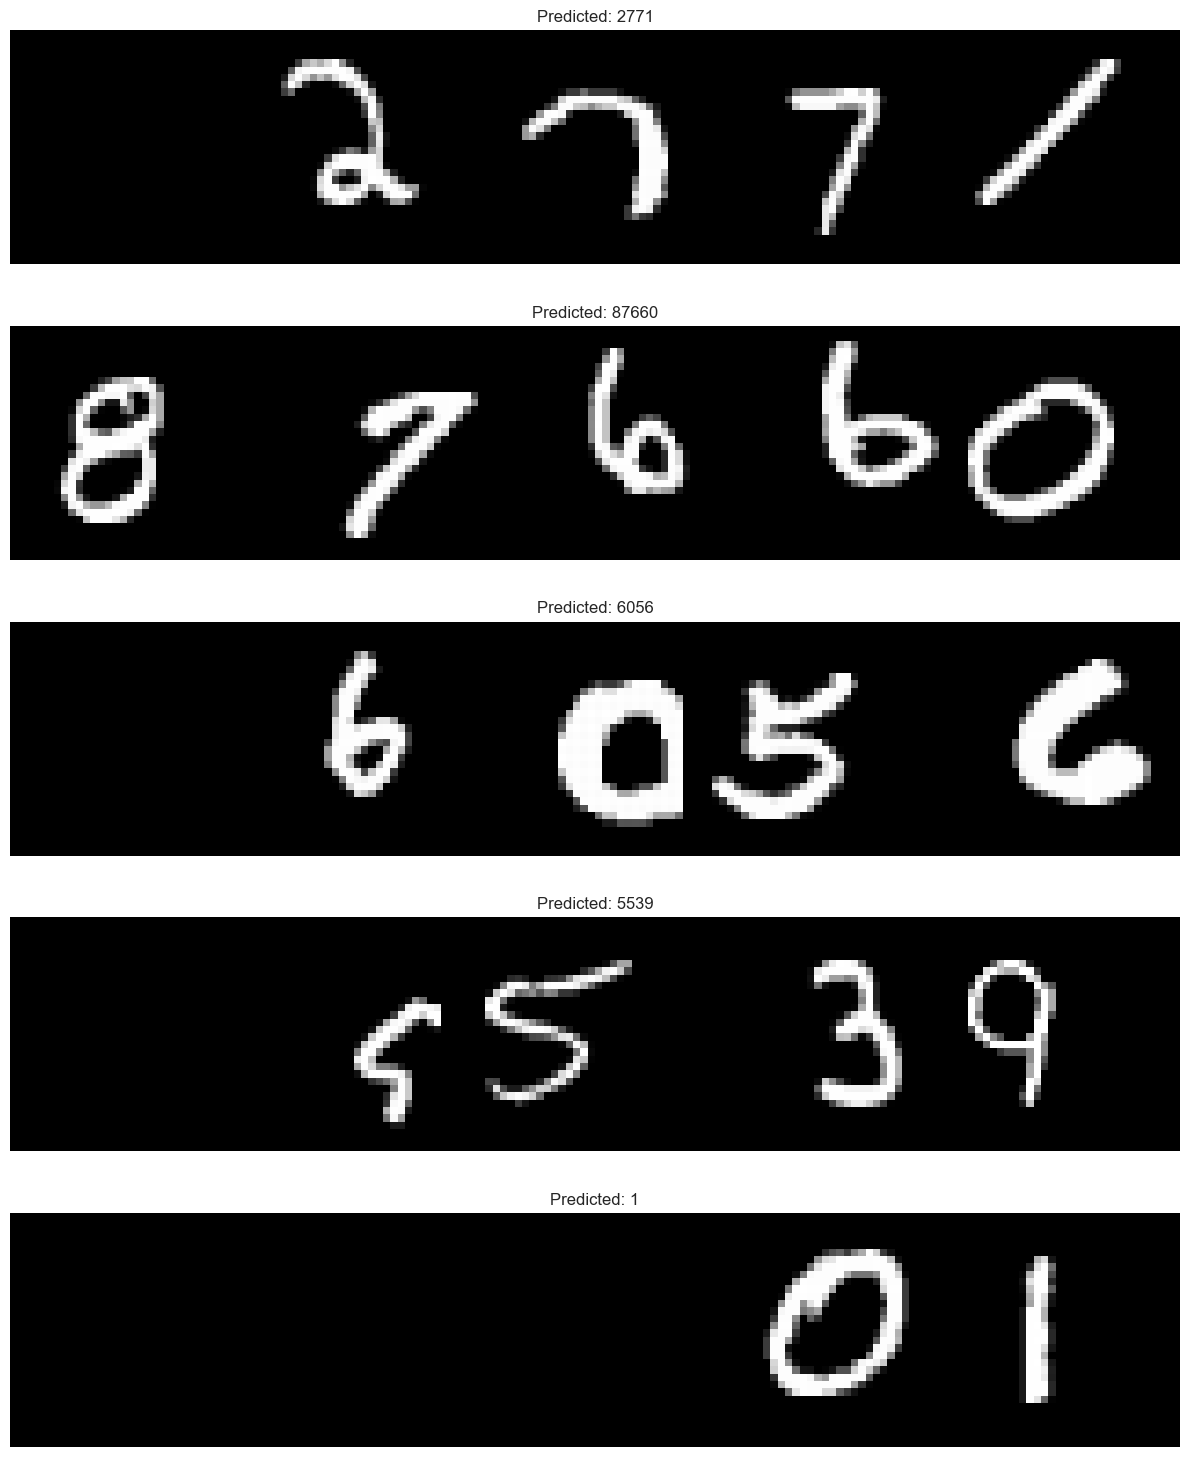

Ground truth (padded):
tensor([[10,  2,  7,  7,  1],
        [ 8,  7,  6,  6,  0],
        [10,  6,  0,  5,  6],
        [10,  5,  5,  3,  9],
        [10, 10, 10, 10,  1]])


In [16]:
# =====================================================================
# Prediction helper
# =====================================================================

def predict(model: MultiDigitModel, batch: Tensor) -> List[int]:
    """
    Convert model outputs into integer multi-digit numbers.
    Blank symbol is assumed to be (num_classes - 1).
    """
    model.eval()
    preds_list: List[int] = []

    with torch.inference_mode():
        batch = batch.to(CFG.device)
        logits = model(batch)                         # [B, N, C]
        digit_indices = logits.argmax(dim=-1).cpu()   # [B, N]

        blank_idx = model.num_classes - 1
        for seq in digit_indices:
            valid = seq[seq != blank_idx].tolist()
            if not valid:
                preds_list.append(0)
            else:
                as_str = "".join(map(str, valid))
                preds_list.append(int(as_str))

    return preds_list


# Small qualitative check
sample_images, sample_labels = next(iter(val_loader))
sample_images = sample_images[:5]
sample_labels = sample_labels[:5]

pred_labels = predict(model, sample_images)
show_images_with_labels(sample_images, pred_labels)
print("Ground truth (padded):")
print(sample_labels)